## nsdmd generative model development


This model is used to do model comparison on four Dark Matter density profiles. The model compared 4 density files: NFW profile, Isothermal profile, Einasto profile and Generalized DM profile by comparing their log evidence in fitting rotational velocity cruve. We use the model density file with unknown parametes to calculate the enclosing mass and the corresponding rotational velocity. Then we use nestle sampling package to find the fitting paramters for the function.

### Model
Model 

$ M $ = The rotational curve calculated with the existence of dark matter and the dark matter density is given by the density profile. We have four dark matter density files and give us 4 models to compare. 

The posterior distribution is calculated as, $ p(M|D,I) = \frac{p(M|I) p(D|M, I)}{p(D|I)} $



### The four Dark Matter density profiles models: 

Note that

r: galactocentric radius

$ \rho( r ) $ : Dark Matter Density as a function of galactocentric radius


### (1) NFW profile :

 $ \rho \left( r \right) \propto \frac{1}{{\left( r/a \right)}{\left[ 1~+~{{\left( r/a \right)}} \right]}^{2}} $
 
 For distances close to the galactic center, $r \ll a$, the density increases as 1/$r$.  At large distances, $r \gg a$, the density decreases as 1/$r^3$. As the distance to the galactic center increases, the rotational velocity decreases.


### (2) Isothermal profile:

  $  \rho \left( r \right) \propto \frac{1}{{\left[ 1~+~{{\left( r/a \right)}^{2}} \right]}} $
  
For distances close to the galactic center, $r \ll a$, the density  becomes constant.  At large distances, $r \gg a$, the density decreases as 1/$r^2$.

### (3) Einasto profile :

$ \rho \left( r \right) \propto \exp \left\{ { - 2n\left[ {{{\left( {\frac{r}{a}} \right)}^{1/n}} - 1} \right]} \right\} $

The Einasto profile has two free parameters: the Einasto index $n$, which defines the shape of the profile, and the scale radius $a$. For distances close to the galactic center, $r~\ll~a$, the density approaches a constant value, proportional to $\exp \left\{ {2n} \right\}$.  

### (4) Generalized DM profile :

 $ \rho \left( r \right) \propto    \frac{1}{{\left( r/a \right)}^{\gamma}{\left[ 1~+~{{\left( r/a \right)}^{\alpha}} \right]}^{ \frac{(\beta - \gamma)}{\alpha}}} $

The profile has four free parameters: the scale radius $a$ and $\alpha$, $\beta$, and $\gamma$.  We can put constraints on some of the parameters by requiring that the density remains finite at small distance and that the enclosed mass reaches a limit at large distances.  For distances close to the galactic center, $r~\ll~a$, the density is proportional to as 1/$r^{\gamma}$. The requirement that the enclosed mass remains finite at small $r$ requires that $\gamma~<~3$.  At large distances, $r~\gg~a$, the density decreases as 1/$r^\beta$.  The requirement that the enclosed mass in spherical shells that these distances approaches zero requires that  $\beta~\geq~3$.


### We can calcuate rotational curve from Dark Matter density profiles, by assuming dark matter distribution is spherically symmetric

$ \frac{GMm}{4 \pi  R^2} = \frac {m v^2}{R}$  where $M=\int_{R_o}^{R} \rho (r) 4 \pi  R^2 dr$

$v_{calculated} = \sqrt { \frac{ G   \int_{R_o}^{R} \rho (r) 4 \pi  r^2 dr} {4 \pi  r}  }   $


In [20]:
  #  !!!! pip install nestle  (from terminal)
    
# !conda install -y -c conda-forge nestle (somehow couldn't find nestle)

In [21]:
import numpy as np
import nestle
import math

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import corner

from scipy.integrate import quad

from nsdmd import model 
from nsdmd import io

import pandas as pd



### The data will be used in this project is the measured rotational speed of the interstellar medium in our local galaxy, as shown in the following figure. 

In [22]:
# Define the data for two references:
# Reference 1: Bhattacharjee et. al.
# Reference 2: Sofue 
### The data will be used in this project is the measured rotational speed of the interstellar medium in our local galaxy, as shown in the following figure. 


#load data
data_x_ref1,data_xerr_ref1,data_y_ref1,data_yerr_ref1 =io.load_data('dataref1.txt')
data_x_ref2,data_xerr_ref2,data_y_ref2,data_yerr_ref2 =io.load_data('dataref2.txt')

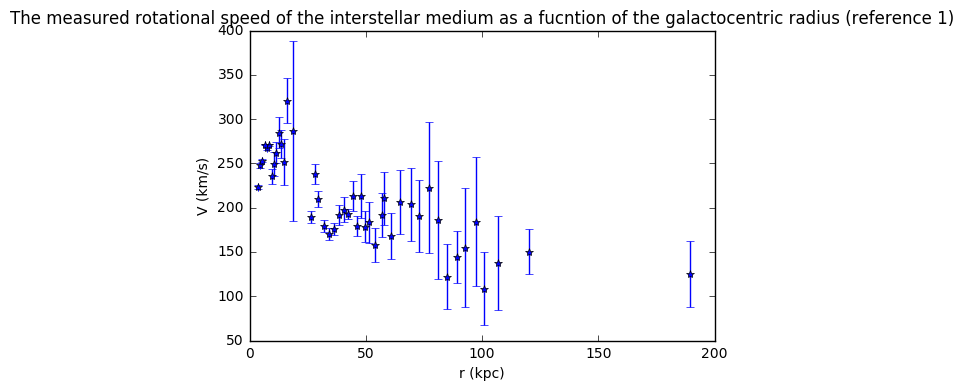

In [23]:
data_xerr = data_xerr_ref1
plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
plt.show()

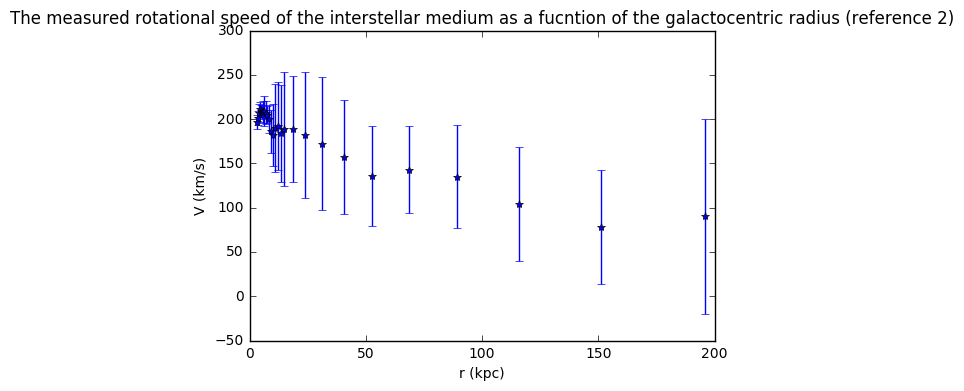

In [24]:
data_xerr = 0
plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
plt.show()

### The log likelihood is meant to capture how well a model is able to reproduce the data that it is meant to simulate.

$log p(D|M, I) = constant* \prod_{i}^{} log(\sigma_i)  \sum_{i}{}(\frac{(v_{icalculated} - v_{imeasured})^2}{2 \sigma_i^2}) $

$constant* \prod_{i}^{} log(\sigma_i) $, this part doesn't matter much since they are the same for all. 

$log p(D|M, I) =  \sum_{i}{}(\frac{(v_{icalculated} - v_{imeasured})^2}{2 \sigma_i^2}) $

In [25]:
# Define the model we use to describe the data.
# The NFW model.

def model_NFW(theta, x):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    #
    # Note: the mass defined here does not include the normalization constant rho0 (kg/kpc^3).
    # The units of a are kpc.
    # The units of the "mass" calculated here are thus kpc^3.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+x)/a)-x/(a+x))
        
    # Calculate the rotation velocity: vrot = theta[1]*sqrt(mass/x)
    # The units of sqrt(mass/x) are kpc.
    # The rotation velocity is equal to sqrt(G*rho0)*sqrt((M/rho0)/x) where M is the mass enclosed, 
    # rho0 is the normalization constant of the mass distribution, and x is the distance at which we
    # calculate vrot.
    # When we determine theta[1], we determine sqrt(G*rho0).
    # The units of vrot are km/s.
    # The units of sqrt(mass/x) are kpc.
    # The units of theta[1] are thus (km/s)/kpc = (10^3 m)/s/(3.086E19 m) = 3.24E-17 1/s.
    # Since theta[1] = sqrt(G*rho0) we can now determine rho0: rho0 = theta[1]^2/G.
    # The units on the right-hand side are: (3.24E-17 1/s)^2/(m^3/(kg s^2)) = (3.24E-17)^2 kg/(m^3)
    # To convert from kg/m^3 to kg/kpc^3, we multiply by (3.086E19)^3
    # The normalization constant rho0 is thus (theta1[1]^2)/6.67E-11 * ((3.24E-17)^2 * (3.086E19)^3 kg/(kpc)^3 = 
    # (theta1[1]^2)*4.625E35 kg/(kpc)^3 = 2.312E5 Msun/(kpc)^3.
    vrot = theta[1]*np.sqrt(mass/x) 
    
    return vrot

In [26]:
# Define a likelihood function

def loglike_NFW_ref1(theta):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+data_x_ref1)/a)-data_x_ref1/(a+data_x_ref1))
        
    # Calculate the rotation velocity.
    vrot = theta[1]*np.sqrt(mass/data_x_ref1) 
        
    # The y variable is the rotational velocity.
    y = vrot
    
    # Calculate chisq
    chisq= np.sum(((data_y_ref1 - y) / data_yerr_ref1)**2)
    return -chisq / 2.



In [27]:
# Define a likelihood function
def loglike_NFW_ref2(theta):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+data_x_ref2)/a)-data_x_ref2/(a+data_x_ref2))
        
    # Calculate the rotation velocity.
    vrot = theta[1]*np.sqrt(mass/data_x_ref2) 
        
    # The y variable is the rotational velocity.
    y = vrot
    
    # Calculate chisq
    chisq= np.sum(((data_y_ref2 - y) / data_yerr_ref2)**2)
    return -chisq / 2.



### The prior: 
uniform priors with constraints from literature. 
  

In [28]:
# It is a transformation from a space where variables are independently and uniformly distributed between 0 and 1 to the parameter space of interest. 
# 

def prior_transform_NFW(theta):
    
    # theta[0] in the range of [0,10] and theta[1] in the range of [0,300]
    return  np.array([20, 500]) * theta


In [29]:
# Define the model we use to describe the data.

def model_ISO(theta, x):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    #
    # Note: the mass defined here does not include the normalization constant rho0 (kg/kpc^3).
    # The units of a are kpc.
    # The units of the "mass" calculated here are thus kpc^3.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(x/a - np.arctan(x/a))
        
    # Calculate the rotation velocity: vrot = theta[1]*sqrt(mass/x)
    # The units of sqrt(mass/x) are kpc.
    # The rotation velocity is equal to sqrt(G*rho0)*sqrt((M/rho0)/x) where M is the mass enclosed, 
    # rho0 is the normalization constant of the mass distribution, and x is the distance at which we
    # calculate vrot.
    # When we determine theta[1], we determine sqrt(G*rho0).
    # The units of vrot are km/s.
    # The units of sqrt(mass/x) are kpc.
    # The units of theta[1] are thus (km/s)/kpc = (10^3 m)/s/(3.086E19 m) = 3.24E-17 1/s.
    # Since theta[1] = sqrt(G*rho0) we can now determine rho0: rho0 = theta[1]^2/G.
    # The units on the right-hand side are: (3.24E-17 1/s)^2/(m^3/(kg s^2)) = (3.24E-17)^2 kg/(m^3)
    # To convert from kg/m^3 to kg/kpc^3, we multiply by (3.086E19)^3
    # The normalization constant rho0 is thus (theta1[1]^2)/6.67E-11 * ((3.24E-17)^2 * (3.086E19)^3 kg/(kpc)^3 = 
    # (theta1[1]^2)*4.625E35 kg/(kpc)^3 = 2.312E5 Msun/(kpc)^3.
    vrot = theta[1]*np.sqrt(mass/x) 
    
    return vrot

In [30]:
# Define a likelihood function
def loglike_ISO_ref1(theta):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(data_x_ref1/a - np.arctan(data_x_ref1/a))
        
    # Calculate the rotation velocity.
    vrot = theta[1]*np.sqrt(mass/data_x_ref1) 
        
    # The y variable is the rotational velocity.
    y = vrot
    
    # Calculate chisq
    chisq= np.sum(((data_y_ref1 - y) / data_yerr_ref1)**2)
    return -chisq / 2.


In [31]:
def loglike_ISO_ref2(theta):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(data_x_ref2/a - np.arctan(data_x_ref2/a))
        
    # Calculate the rotation velocity.
    vrot = theta[1]*np.sqrt(mass/data_x_ref2) 
        
    # The y variable is the rotational velocity.
    y = vrot
    
    # Calculate chisq
    chisq= np.sum(((data_y_ref2 - y) / data_yerr_ref2)**2)
    return -chisq / 2.



In [32]:
# It is a transformation from a space where variables are independently and uniformly distributed between 0 and 1 to the parameter space of interest. 
# 

def prior_transform_ISO(theta):
    
    # theta[0] in the range of [0,10] and theta[1] in the range of [0,300]
    return  np.array([5, 1000]) * theta



In [33]:
# Define the model we use to describe the data.
# The Einasto model.

#
# Start with defining the Einasto desity function.

def rho_Einasto(x,a,n):
    
    # Calculate the Einasto density.
    # The units of a are kpc.
    # n is dimensionless
    # The units of x are kpc.
    
    # Calculate the density.
    rho = np.exp(-2.*n*(x/a)**(1./n) - 1.)

    # Return the density
    return rho


def integrand_Einasto(x,a,n):
    
    # Calculate the integrand for mass integration.
    # This is x**2 * rho
    
    # Calculate the density.
    rho = rho_Einasto(x,a,n)

    # Return the density
    return rho*x**2


def mass_Einasto(theta, x):
    
    # Calculate the mass between 0 and data_x by integrating the Einasto distribution.
    #
    # Note: the mass defined here does not include the normalization constant rho0 (kg/kpc^3).
    # The units of a are kpc.
    # n is dimensionless
    # The units of the "mass" calculated here are thus kpc^3.
    a = theta[0]
    n = theta[1]
    
    mass, err = quad(integrand_Einasto,0,x,args=(a,n))
    mass = 4.*np.pi*mass
        
    return mass


def model_Einasto(theta, x):
    
    # Calculate the mass between 0 and data_x by integrating the Einasto distribution.
    #
    # Note: the mass defined here does not include the normalization constant rho0 (kg/kpc^3).
    # The units of a are kpc.
    # n is dimensionless
    # The units of the "mass" calculated here are thus kpc^3.
    a = theta[0]
    n = theta[1]
    
    mass, err = quad(integrand_Einasto,0,x,args=(a,n))
    mass = 4.*np.pi*mass
        
    # Calculate the rotation velocity: vrot = theta[1]*sqrt(mass/x)
    # The units of sqrt(mass/x) are kpc.
    # The rotation velocity is equal to sqrt(G*rho0)*sqrt((M/rho0)/x) where M is the mass enclosed, 
    # rho0 is the normalization constant of the mass distribution, and x is the distance at which we
    # calculate vrot.
    # When we determine theta[1], we determine sqrt(G*rho0).
    # The units of vrot are km/s.
    # The units of sqrt(mass/x) are kpc.
    # The units of theta[2] are thus (km/s)/kpc = (10^3 m)/s/(3.086E19 m) = 3.24E-17 1/s.
    # Since theta[1] = sqrt(G*rho0) we can now determine rho0: rho0 = theta[1]^2/G.
    # The units on the right-hand side are: (3.24E-17 1/s)^2/(m^3/(kg s^2)) = (3.24E-17)^2 kg/(m^3)
    # To convert from kg/m^3 to kg/kpc^3, we multiply by (3.086E19)^3
    # The normalization constant rho0 is thus (theta1[1]^2)/6.67E-11 * ((3.24E-17)^2 * (3.086E19)^3 kg/(kpc)^3 = 
    # (theta1[1]^2)*4.625E35 kg/(kpc)^3 = 2.312E5 Msun/(kpc)^3.
    vrot = theta[2]*np.sqrt(mass/x) 
    
    return vrot

In [34]:
# Define a likelihood function
def loglike_Einasto_ref1(theta):
    
    # Set chisq to zero.
    chisq = 0.

    # Note: we use this loop to determine chisq since mass_Einasto has a problem 
    # when data_x_ref1 is used as an argument.
    for index in range(len(data_x_ref1)):
        mass = mass_Einasto(theta,data_x_ref1[index])
        vrot = theta[2]*np.sqrt(mass/data_x_ref1[index]) 
        y = vrot
        chisq = chisq + ((data_y_ref1[index] - y) / data_yerr_ref1[index])**2
        
    return -chisq / 2.



In [35]:
# Define a likelihood function
def loglike_Einasto_ref2(theta):
    
    # Set chisq to zero.
    chisq = 0.

    # Note: we use this loop to determine chisq since mass_Einasto has a problem 
    # when data_x_ref2 is used as an argument.
    for index in range(len(data_x_ref2)):
        mass = mass_Einasto(theta,data_x_ref2[index])
        vrot = theta[2]*np.sqrt(mass/data_x_ref2[index]) 
        y = vrot
        chisq = chisq + ((data_y_ref2[index] - y) / data_yerr_ref2[index])**2
        
    return -chisq / 2.


In [36]:
# It is a transformation from a space where variables are independently and uniformly distributed between 0 and 1 to the parameter space of interest. 
# 

def prior_transform_Einasto(theta):
    
    # theta[0] and theta[1] in the range of [0,10] and theta[1] in the range of [0,500]
    return  np.array([10, 10, 500]) * theta




Therefore, we can calculated the posterior $ p(M|D,I) = \frac{p(M|I) p(D|M, I)}{p(D|I)} $ and compare the posterior by MCMC and/or Nestle to do model comparison. 

By using the Nestle package, it will give us log evidence, numerical (sampling) error on logz, array of sample parameters, array of weights associated with each sampleand result.weights. 

In [37]:
# Run nested sampling.
# Start with the NFW distribution

# Start with reference 1

result_NFW_ref1 = nestle.sample(loglike_NFW_ref1, prior_transform_NFW, 2)

print ('Number of iterations')
print (result_NFW_ref1.niter)

print ('log evidence')
print (result_NFW_ref1.logz)

print ('numerical (sampling) error on logz')
print (result_NFW_ref1.logzerr)   
       
print ('array of sample parameters')
print (result_NFW_ref1.samples)  
       
print ('array of weights associated with each sample')
print (result_NFW_ref1.weights)

# Continue with reference 2

result_NFW_ref2 = nestle.sample(loglike_NFW_ref2, prior_transform_NFW, 2)

print ('Number of iterations')
print (result_NFW_ref2.niter)

print ('log evidence')
print (result_NFW_ref2.logz)

print ('numerical (sampling) error on logz')
print (result_NFW_ref2.logzerr)   
       
print ('array of sample parameters')
print (result_NFW_ref2.samples)  
       
print ('array of weights associated with each sample')
print (result_NFW_ref2.weights)


Number of iterations
1274
log evidence
-281.156197679
numerical (sampling) error on logz
0.3292393807500404
array of sample parameters
[[  19.47924239  463.58230583]
 [  18.29470677  472.26413558]
 [  13.95771208  493.37809359]
 ..., 
 [   3.3073262    48.97846328]
 [   3.25523805   49.72613137]
 [   3.37148327   47.99117367]]
array of weights associated with each sample
[ 0.          0.          0.         ...,  0.00337147  0.00335002
  0.00362781]
Number of iterations
933
log evidence
-9.54753203332
numerical (sampling) error on logz
0.2729552231614117
array of sample parameters
[[  19.37445075  476.65095253]
 [  17.80208845  498.92919885]
 [  17.3186632   469.65794381]
 ..., 
 [   2.8698257    44.25451885]
 [   2.60463741   48.00090307]
 [   2.14248056   58.68725065]]
array of weights associated with each sample
[ 0.          0.          0.         ...,  0.00310569  0.00377287
  0.00318708]


In [38]:
# Run nested sampling.
# Start with the ISO distribution

# Start with reference 1

result_ISO_ref1 = nestle.sample(loglike_ISO_ref1, prior_transform_ISO, 2)

print ('Number of iterations')
print (result_ISO_ref1.niter)

print ('log evidence')
print (result_ISO_ref1.logz)

print ('numerical (sampling) error on logz')
print (result_ISO_ref1.logzerr)   
       
print ('array of sample parameters')
print (result_ISO_ref1.samples)  
       
print ('array of weights associated with each sample')
print (result_ISO_ref1.weights)

# Continue with reference 2

result_ISO_ref2 = nestle.sample(loglike_ISO_ref2, prior_transform_ISO, 2)

print ('Number of iterations')
print (result_ISO_ref2.niter)

print ('log evidence')
print (result_ISO_ref2.logz)

print ('numerical (sampling) error on logz')
print (result_ISO_ref2.logzerr)   
       
print ('array of sample parameters')
print (result_ISO_ref2.samples)  
       
print ('array of weights associated with each sample')
print (result_ISO_ref2.weights)



Number of iterations
1243
log evidence
-858.872571819
numerical (sampling) error on logz
0.3207609720509122
array of sample parameters
[[  4.88503457e+00   8.89630047e+02]
 [  3.97783311e+00   9.75946305e+02]
 [  4.74555489e+00   8.32304136e+02]
 ..., 
 [  7.74344345e-02   9.67407503e+02]
 [  7.72420882e-02   9.70544268e+02]
 [  7.72238187e-02   9.70647699e+02]]
array of weights associated with each sample
[ 0.          0.          0.         ...,  0.0031746   0.00330764
  0.00334664]
Number of iterations
869
log evidence
-16.4405726354
numerical (sampling) error on logz
0.26190231596760327
array of sample parameters
[[  4.41422424e+00   9.77108160e+02]
 [  4.90638330e+00   9.31873341e+02]
 [  4.70040161e+00   9.15246177e+02]
 ..., 
 [  6.36326003e-02   9.21275171e+02]
 [  8.15037384e-02   7.22528965e+02]
 [  6.52812855e-02   8.95418839e+02]]
array of weights associated with each sample
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.0000

Results based on fits to the data from reference 1:
Core radius a =  3.32 +/-  0.10 kpc
Normalization factor = 48.83 +/-  1.53 km/s/kpc
Halo density normalization constant = 1.13e+07 +/- 3.53e+05 Msun/kpc^3
Halo density in our solor system = 6.17e+07 Msun/kpc^3.
Halo density in our solor system = 2.35e+03 GeV/c^2/liter.


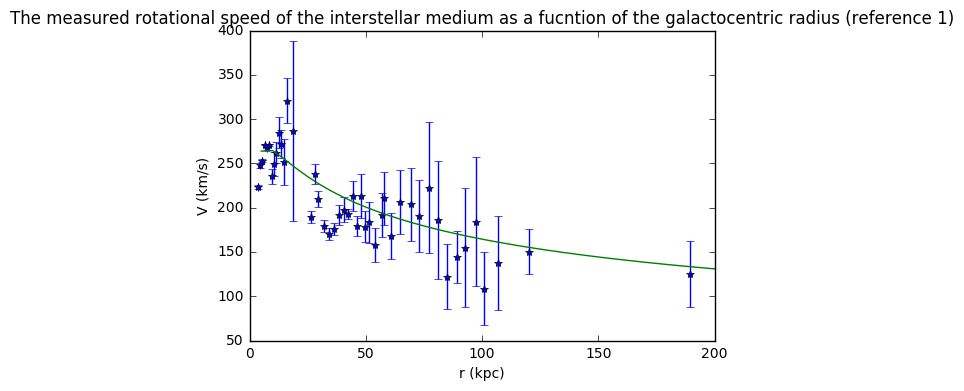

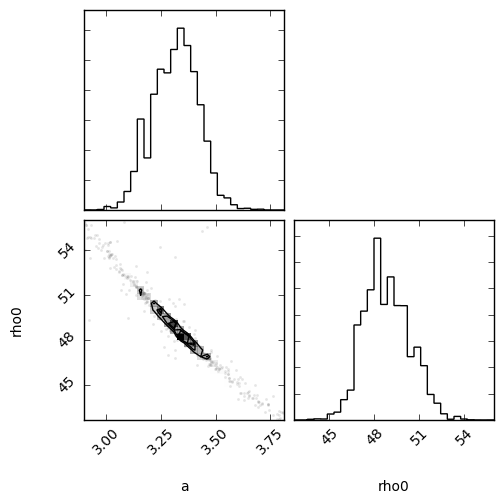

Results based on fits to the data from reference 1:
Core radius a =  2.56 +/-  0.57 kpc
Normalization factor = 51.74 +/- 11.89 km/s/kpc
Halo density normalization constant = 1.20e+07 +/- 2.75e+06 Msun/kpc^3
Halo density in our solor system = 4.98e+07 Msun/kpc^3.
Halo density in our solor system = 1.90e+03 GeV/c^2/liter.


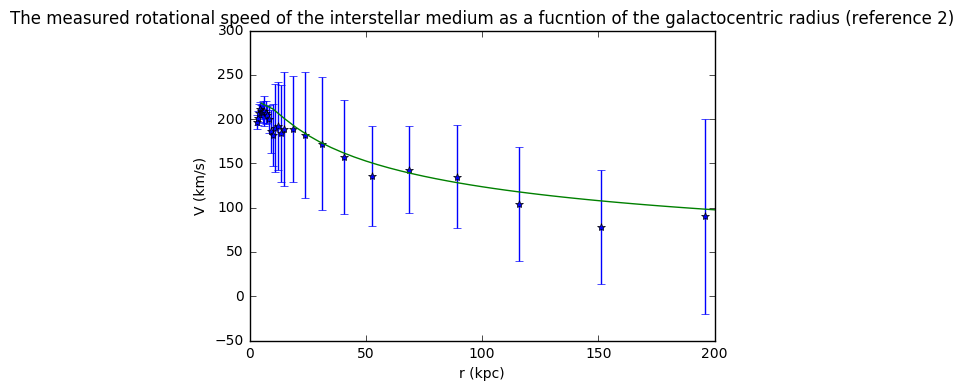

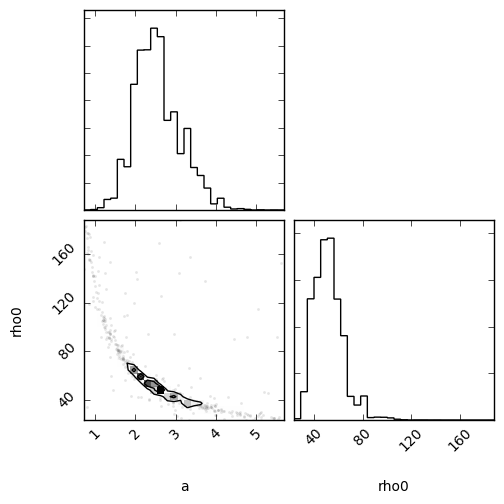

In [39]:
data_xerr = 0

# Analyze the results of fits with the NFW model.
#
# Get the results of the fit and the uncertainties in the fit parameters.
p_NFW_ref1, cov_NFW_ref1 = nestle.mean_and_cov(result_NFW_ref1.samples, result_NFW_ref1.weights)
p_NFW_ref2, cov_NFW_ref2 = nestle.mean_and_cov(result_NFW_ref2.samples, result_NFW_ref2.weights)

# Start with printing the results of the fit based on the data from reference 1
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_NFW_ref1[0], np.sqrt(cov_NFW_ref1[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_NFW_ref1[1], np.sqrt(cov_NFW_ref1[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_NFW_ref1[1], 
                                                                                      2.312E5*np.sqrt(cov_NFW_ref1[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_NFW(p_NFW_ref1, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_NFW(p_NFW_ref1, 8)))

plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_NFW(p_NFW_ref1, xplot))
plt.show()

fig = corner.corner(result_NFW_ref1.samples, weights=result_NFW_ref1.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()


# Continue with printing the results of the fit based on the data from reference 2
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_NFW_ref2[0], np.sqrt(cov_NFW_ref2[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_NFW_ref2[1], np.sqrt(cov_NFW_ref2[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_NFW_ref2[1], 
                                                                                      2.312E5*np.sqrt(cov_NFW_ref2[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_NFW(p_NFW_ref2, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_NFW(p_NFW_ref2, 8)))

plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_NFW(p_NFW_ref2, xplot))
plt.show()

fig = corner.corner(result_NFW_ref2.samples, weights=result_NFW_ref2.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

Results based on fits to the data from reference 1:
Core radius a =  0.08 +/-  0.01 kpc
Normalization factor = 920.29 +/- 71.52 km/s/kpc
Halo density normalization constant = 2.13e+08 +/- 1.65e+07 Msun/kpc^3
Halo density in our solor system = 6.14e+07 Msun/kpc^3.
Halo density in our solor system = 2.34e+03 GeV/c^2/liter.


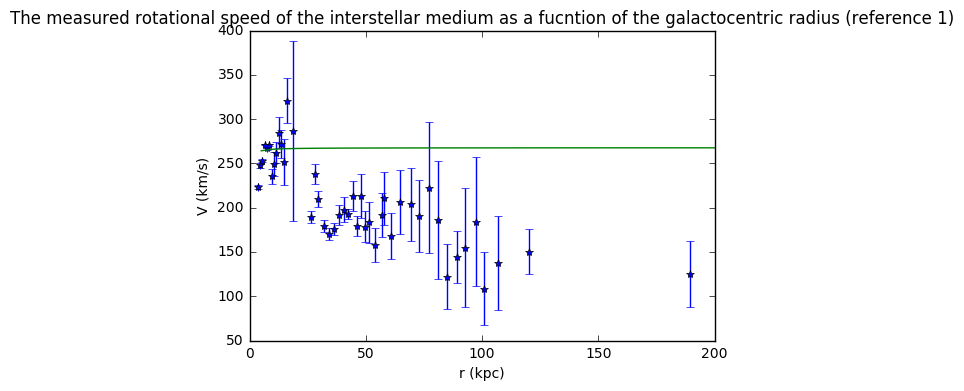

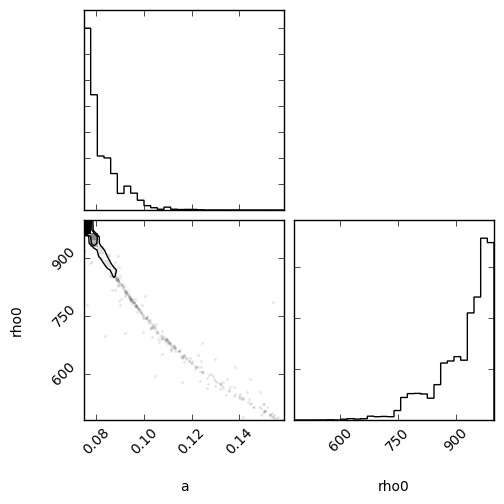

Results based on fits to the data from reference 1:
Core radius a =  0.13 +/-  0.08 kpc
Normalization factor = 561.74 +/- 236.28 km/s/kpc
Halo density normalization constant = 1.30e+08 +/- 5.46e+07 Msun/kpc^3
Halo density in our solor system = 6.02e+07 Msun/kpc^3.
Halo density in our solor system = 2.30e+03 GeV/c^2/liter.


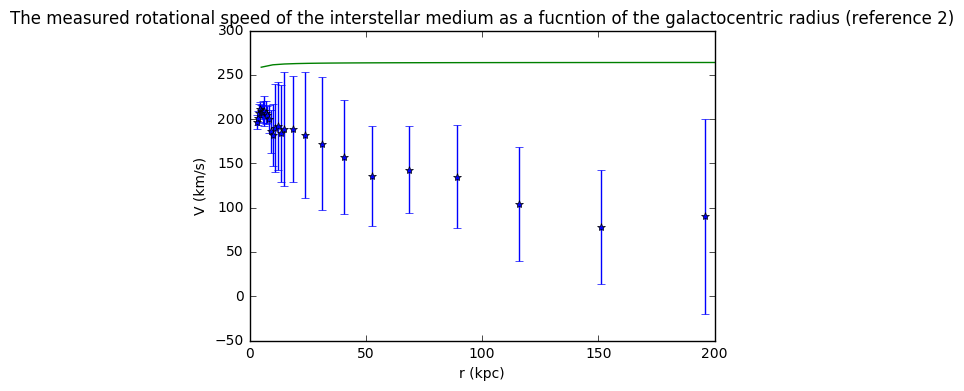

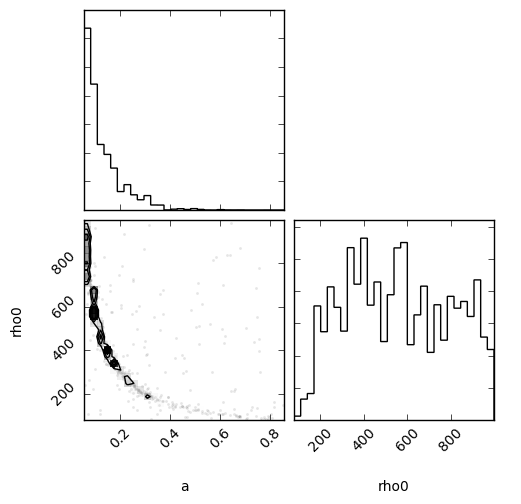

In [40]:
data_xerr = 0

# Analyze the results of fits with the ISO model.
#
# Get the results of the fit and the uncertainties in the fit parameters.
p_ISO_ref1, cov_ISO_ref1 = nestle.mean_and_cov(result_ISO_ref1.samples, result_ISO_ref1.weights)
p_ISO_ref2, cov_ISO_ref2 = nestle.mean_and_cov(result_ISO_ref2.samples, result_ISO_ref2.weights)

# Start with printing the results of the fit based on the data from reference 1
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ISO_ref1[0], np.sqrt(cov_ISO_ref1[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_ISO_ref1[1], np.sqrt(cov_ISO_ref1[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ISO_ref1[1], 
                                                                                      2.312E5*np.sqrt(cov_ISO_ref1[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_ISO(p_ISO_ref1, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_ISO(p_ISO_ref1, 8)))

plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_ISO(p_ISO_ref1, xplot))
plt.show()

fig = corner.corner(result_ISO_ref1.samples, weights=result_ISO_ref1.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()


# Continue with printing the results of the fit based on the data from reference 2
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ISO_ref2[0], np.sqrt(cov_ISO_ref2[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_ISO_ref2[1], np.sqrt(cov_ISO_ref2[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ISO_ref2[1], 
                                                                                      2.312E5*np.sqrt(cov_ISO_ref2[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_ISO(p_ISO_ref2, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_ISO(p_ISO_ref2, 8)))

plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_ISO(p_ISO_ref2, xplot))
plt.show()

fig = corner.corner(result_ISO_ref2.samples, weights=result_ISO_ref2.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

In [41]:
# Run nested sampling.
# Start with the Einasto distribution

# Start with reference 1

result_Einasto_ref1 = nestle.sample(loglike_Einasto_ref1, prior_transform_Einasto, 3)

print ('Number of iterations')
print (result_Einasto_ref1.niter)

print ('log evidence')
print (result_Einasto_ref1.logz)

print ('numerical (sampling) error on logz')
print (result_Einasto_ref1.logzerr)   
       
print ('array of sample parameters')
print (result_Einasto_ref1.samples)  
       
print ('array of weights associated with each sample')
print (result_Einasto_ref1.weights)

# Continue with reference 2

result_Einasto_ref2 = nestle.sample(loglike_Einasto_ref2, prior_transform_Einasto, 3)

print ('Number of iterations')
print (result_Einasto_ref2.niter)

print ('log evidence')
print (result_Einasto_ref2.logz)

print ('numerical (sampling) error on logz')
print (result_Einasto_ref2.logzerr)   
       
print ('array of sample parameters')
print (result_Einasto_ref2.samples)  
       
print ('array of weights associated with each sample')
print (result_Einasto_ref2.weights)



/Users/margin/anaconda/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


Number of iterations
1460
log evidence
-108.732656974
numerical (sampling) error on logz
0.35063056763701533
array of sample parameters
[[  6.99397646e+00   3.13408474e-01   4.54881424e+02]
 [  5.73309946e+00   4.72826724e-01   4.62469470e+02]
 [  8.23061853e+00   2.68261888e-01   2.62481914e+02]
 ..., 
 [  4.86340137e+00   1.58886962e+00   1.46175805e+02]
 [  4.92701678e+00   1.64347490e+00   1.51656086e+02]
 [  4.79682027e+00   1.66796305e+00   1.59111983e+02]]
array of weights associated with each sample
[ 0.          0.          0.         ...,  0.00217086  0.00228409
  0.00243447]
Number of iterations
938
log evidence
-10.6764307684
numerical (sampling) error on logz
0.26647161104056916
array of sample parameters
[[  9.35406676e+00   3.25060379e-01   3.36800694e+02]
 [  7.69047012e+00   6.03272222e-01   4.04871656e+02]
 [  4.96852562e+00   5.61669860e-01   4.34760438e+02]
 ..., 
 [  2.90933823e+00   2.42019914e+00   4.15378417e+02]
 [  2.97424969e+00   2.54720681e+00   4.57874344e

Results based on fits to the data from reference 1:
Core radius a =  4.87 +/-  0.09 kpc
n =  1.63 +/-  0.08
Normalization factor = 152.72 +/- 13.51 km/s/kpc
Halo density normalization constant = 3.53e+07 +/- 3.12e+06 Msun/kpc^3
Halo density in our solor system = 6.34e+07 Msun/kpc^3.
Halo density in our solor system = 2.42e+03 GeV/c^2/liter.


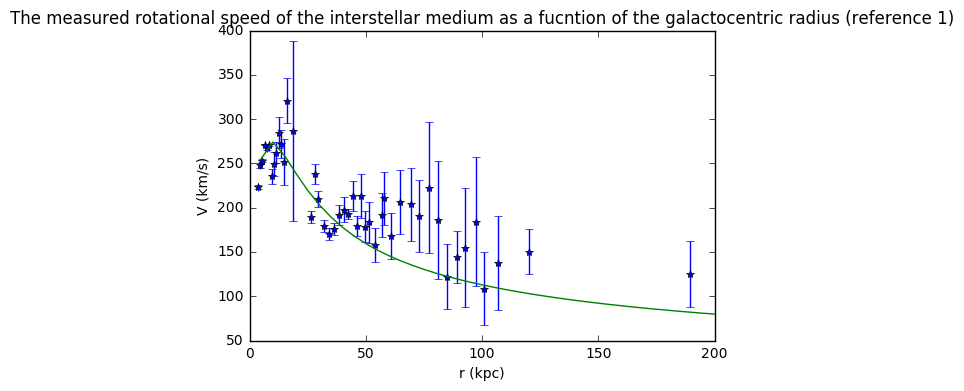

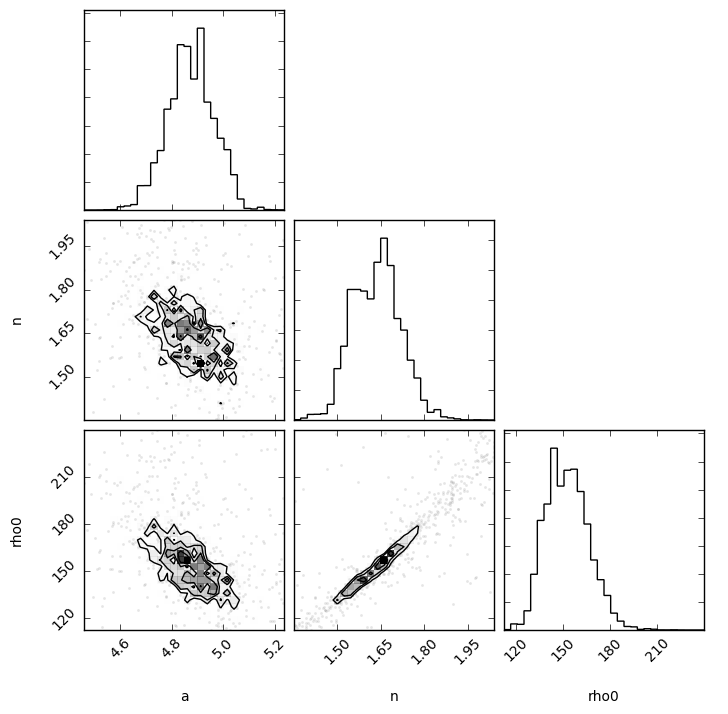

Results based on fits to the data from reference 1:
Core radius a =  3.23 +/-  0.45 kpc
n =  2.34 +/-  0.34
Normalization factor = 368.63 +/- 92.50 km/s/kpc
Halo density normalization constant = 8.52e+07 +/- 2.14e+07 Msun/kpc^3
Halo density in our solor system = 5.08e+07 Msun/kpc^3.
Halo density in our solor system = 1.94e+03 GeV/c^2/liter.


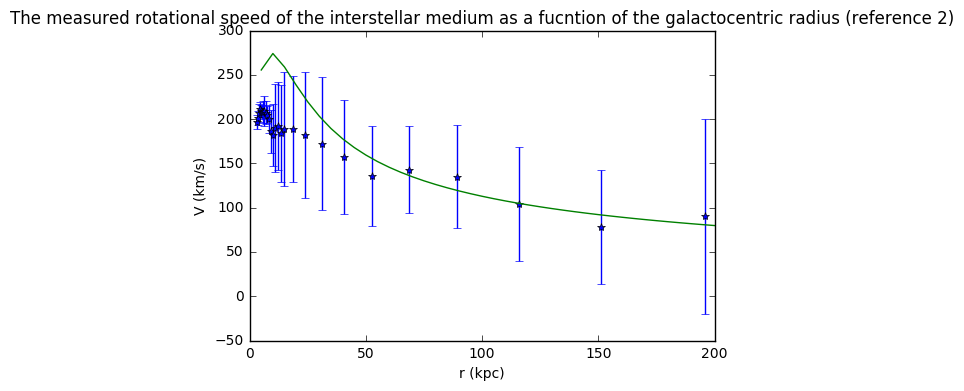

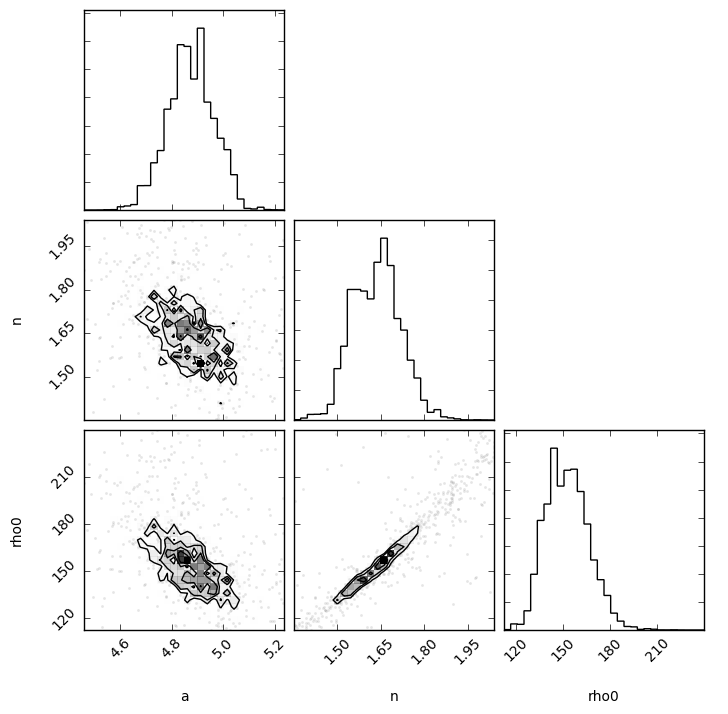

In [42]:
data_xerr = 0

# Analyze the results of fits with the Einasto model.
#
# Get the results of the fit and the uncertainties in the fit parameters.
p_Einasto_ref1, cov_Einasto_ref1 = nestle.mean_and_cov(result_Einasto_ref1.samples, result_Einasto_ref1.weights)
p_Einasto_ref2, cov_Einasto_ref2 = nestle.mean_and_cov(result_Einasto_ref2.samples, result_Einasto_ref2.weights)

# Start with printing the results of the fit based on the data from reference 1
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_Einasto_ref1[0], np.sqrt(cov_Einasto_ref1[0, 0])))
print("n = {0:5.2f} +/- {1:5.2f}".format(p_Einasto_ref1[1], np.sqrt(cov_Einasto_ref1[1, 1])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_Einasto_ref1[2], np.sqrt(cov_Einasto_ref1[2, 2])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_Einasto_ref1[2], 
                                                                                      2.312E5*np.sqrt(cov_Einasto_ref1[2, 2])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_Einasto(p_Einasto_ref1, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_Einasto(p_Einasto_ref1, 8)))

plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
xplot = [5.+5.*i for i in range(40)]
yplot = [model_Einasto(p_Einasto_ref1, xplot[i]) for i in range(40)]
plt.plot(xplot,yplot)
plt.show()

fig = corner.corner(result_Einasto_ref1.samples, weights=result_Einasto_ref1.weights, labels=['a', 'n', 'rho0'],
                    range=[0.99999, 0.99999, 0.99999], bins=30)
plt.show()


# Continue with printing the results of the fit based on the data from reference 2
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_Einasto_ref2[0], np.sqrt(cov_Einasto_ref2[0, 0])))
print("n = {0:5.2f} +/- {1:5.2f}".format(p_Einasto_ref2[1], np.sqrt(cov_Einasto_ref2[1, 1])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_Einasto_ref2[2], np.sqrt(cov_Einasto_ref2[2, 2])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_Einasto_ref2[2], 
                                                                                      2.312E5*np.sqrt(cov_Einasto_ref2[2, 2])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_Einasto(p_Einasto_ref2, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_Einasto(p_Einasto_ref2, 8)))

plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
xplot = [5+5*i for i in range(40)]
yplot = [model_Einasto(p_Einasto_ref1, xplot[i]) for i in range(40)]
plt.plot(xplot,yplot)
plt.show()

fig = corner.corner(result_Einasto_ref1.samples, weights=result_Einasto_ref1.weights, labels=['a', 'n', 'rho0'],
                    range=[0.99999, 0.99999, 0.99999], bins=30)

plt.show()


In [43]:



# Generalized model --> to be continued 
def loglike_GeneralizedDMProfile(theta):
    #theta[4] is the constant proportional factor 

    lensity_GeneralizedDMProfile = 1/(    (data_x /theta[0])**theta[1] *( 1+ (data_x /theta[0])**theta[2] )**2 ) **((theta[3] - theta[1])/theta[2] )
    y=theta[4] * 1
    chisq = np.sum(((data_y - y) / data_yerr)**2)
    return -chisq / 2.



